# Initialization

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import time
import joblib

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
RANDOM_STATE = 0
N_JOBS = 6

In [3]:
import sys
import os

current_folder = os.path.abspath('') 

notebooks_folder = os.path.dirname(current_folder)

project_root = os.path.dirname(notebooks_folder)

if project_root not in sys.path:
    sys.path.append(project_root)

# Reading final test data

In [4]:
final_test_df = pd.read_csv("data/processed/test_language_detection_dataset.csv")
final_test_df.head()

,sentence,lan_code
0,She suspected that it was too late.,eng
1,Я порой бываю рассеян.,rus
2,Он мог бы победить.,rus
3,"Том мог быть не таким счастливым, каким прикид...",rus
4,"Do not forsake me, oh my darling.",eng


In [5]:
X_final_test = final_test_df["sentence"]
y_final_test = final_test_df["lan_code"]

# Initializing models

Here we're gonna initialize our own models as well as three pre-trained popular models for language detection - Lingua, fast-langdetect and XLM-RoBERTa, all of which feature all 3 of our languages, to compare perfomance of our models with already existing ones.

## SGDClassifier-based model

In [6]:
sgd_model_path = "models/dev/sgd_language_detection_model.joblib"

In [8]:
sgd_model = joblib.load(sgd_model_path)
sgd_model

,clf,Pipeline(step...om_state=0))])
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None
,stop_words,None
,token_pattern,'(?u)\\b\\w\\w+\\b'
,ngram_range,"(1, ...)"


## MultinomialNB-based model

In [7]:
mnb_model_path = "models/dev/mnb_language_detection_model.joblib"

In [9]:
mnb_model = joblib.load(mnb_model_path)
mnb_model

,clf,Pipeline(step...274174e-07))])
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None
,stop_words,None
,token_pattern,'(?u)\\b\\w\\w+\\b'
,ngram_range,"(1, ...)"


## Lingua

In [12]:
from lingua import Language, LanguageDetectorBuilder

In [16]:
languages = [Language.ENGLISH, Language.RUSSIAN, Language.UKRAINIAN]
lingua_detector = LanguageDetectorBuilder.from_languages(*languages).build()

In [62]:
def detect_languages_lingua(series: pd.Series) -> pd.Series:
    codes_map = {
        "en" : "eng",
        "ru" : "rus",
        "uk" : "ukr"
    }

    def get_lang_code(text):
        if not isinstance(text, str) or not text.strip():
            return None
            
        res = lingua_detector.detect_language_of(text)
        
        # Convert Enum to string ISO code (e.g., Language.ENGLISH -> 'EN')
        if res:
            return codes_map[res.iso_code_639_1.name.lower()]
        return "unknown"

    results = series.apply(get_lang_code)

    result_df = pd.DataFrame(results.tolist(), columns=['detected_lang'], index=series.index)
    
    return result_df

## fast-langdetect

In [19]:
from fast_langdetect import detect

In [55]:
def detect_languages_fast_langdetect(series: pd.Series) -> pd.Series:
    clean_series = series.astype(str).str.replace('\n', ' ', regex=False).fillna('')

    codes_map = {
        "en" : "eng",
        "ru" : "rus",
        "uk" : "ukr"
    }

    def safe_detect(text):
        if not text or text.isspace():
            return 'unknown'
        try:
            result = detect(text, model="auto", k=1)
            return codes_map[result[0]['lang']]
        except Exception as e:
            return 'unknown'

    results = clean_series.apply(safe_detect)

    result_df = pd.DataFrame(results.tolist(), columns=['detected_lang'], index=series.index)
    
    return result_df

## XLM-RoBERTa

TBD.

# Testing

In [74]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report, \
                            accuracy_score, recall_score, precision_score

In [75]:
predictors = {
    "sgd": sgd_model.predict,
    "mnb": mnb_model.predict,
    "lingua": detect_languages_lingua,
    "fast-langdetect": detect_languages_fast_langdetect
}

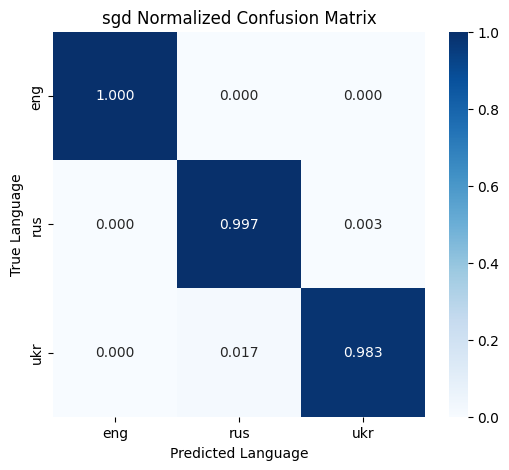

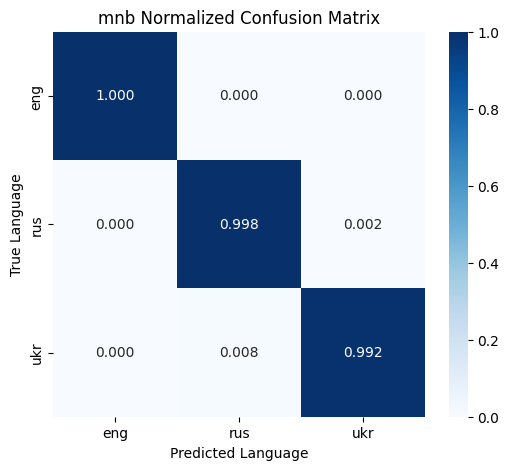

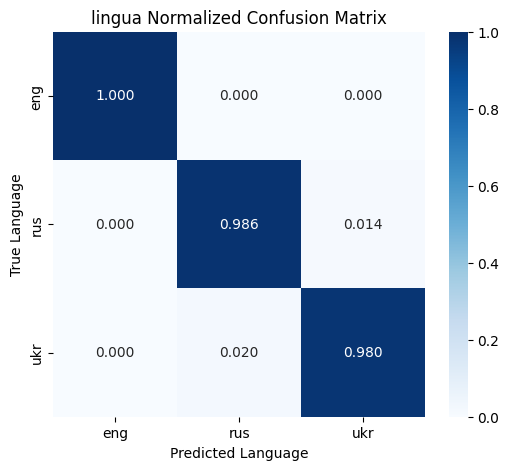

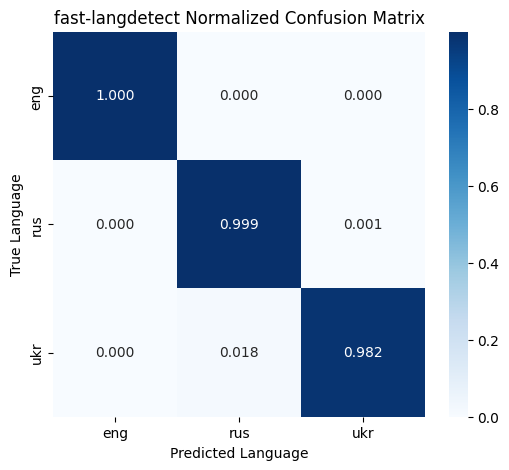

In [76]:
results = []

valid_labels = np.unique(y_final_test)

for name, predictor in predictors.items():
    start_time = time.time()
    
    preds = predictor(X_final_test)
    
    end_time = time.time()
    elapsed = end_time - start_time
    samples_per_sec = len(X_final_test) / elapsed if elapsed > 0 else 0
    
    macro_f1 = f1_score(y_final_test, preds, average='macro', labels=valid_labels, zero_division=0)
    accuracy = accuracy_score(y_final_test, preds)
    
    recalls = recall_score(y_final_test, preds, average=None, labels=valid_labels, zero_division=0)
    precisions = precision_score(y_final_test, preds, average=None, labels=valid_labels, zero_division=0)
    
    row = {
        "Model": name,
        "Macro F1": macro_f1,
        "Accuracy": accuracy,
        "Speed (samples/sec)": int(samples_per_sec)
    }
    
    for i, label in enumerate(valid_labels):
        row[f"{label} Recall"] = recalls[i]
        row[f"{label} Precision"] = precisions[i]
        
    results.append(row)

    cm = confusion_matrix(y_final_test, preds, labels=valid_labels, normalize='true')
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='.3f', 
        cmap='Blues',
        xticklabels=valid_labels,
        yticklabels=valid_labels
    )
    plt.xlabel("Predicted Language")
    plt.ylabel("True Language")
    plt.title(f'{name} Normalized Confusion Matrix')
    plt.show()

In [77]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="Macro F1", ascending=False).reset_index(drop=True)
results_df

,Model,Macro F1,Accuracy,Speed (samples/sec),eng Recall,eng Precision,rus Recall,rus Precision,ukr Recall,ukr Precision
0,mnb,0.996294,0.998754,14173,1.000000,0.999987,0.997883,0.998453,0.992109,0.989334
1,fast-langdetect,0.994919,0.997393,54087,0.998971,1.000000,0.998212,0.996555,0.979170,0.996764
2,sgd,0.993214,0.997719,16705,1.000000,0.999975,0.996586,0.996710,0.983209,0.982804
3,lingua,0.981884,0.993806,24972,1.000000,0.999979,0.985677,0.996083,0.980180,0.930720


In [ ]:
analysis_df = pd.DataFrame({
    'text': X_final_test.values,
    'true_label': y_final_test,
    'predicted': predictors["mnb"](X_final_test)
})

false_english = analysis_df[
    (analysis_df['predicted'] == 'eng') & 
    (analysis_df['true_label'] != 'eng')
]

false_english

,text,true_label,predicted
8939,"Когда изберу время, Я произведу суд по правде....",rus,eng
119485,Текст доступен на условиях лицензии Creative C...,rus,eng
226794,HP означает Hewlett-Packard.,rus,eng


In [80]:
for v in false_english.text:
    print(v)

Когда изберу время, Я произведу суд по правде.
8331956	ina	Forsan vos debe facer un passo a retro e pensar a qui vos es e proque vos face isto.
8331957	tur	Hiç psikolojik tedavi gördünüz mü?
8331958	hun	Tamás 2013 óta tanít.
8331959	hun	Két órája tanul.
8331960	ina	Ha tu jammais essite tractate pro un disturbantia mental?
8331961	hun	Tamás három órája vár.
8331962	hun	Tamás 2013 óta él itt.
8331963	ina	Tom es a schola ora, nonne?
8331964	tur	Uzun süre kalmayı düşünüyor musun?
8331965	hun	Hét teljes napja esik az eső.
8331966	tur	Tom gündüzleri nadiren evde olur.
8331967	ina	Quante tempore passa tu al gymnasio cata septimana?
8331968	epo	Mi estas hundamanto.
8331969	dan	Jeg er kurder.
8331970	epo	Mi estas hundamemulo.
8331971	ina	Que es tu maniera preferite de passar le tempore libere?
8331972	tur	Niye bu kadar terliyorsun?
8331973	ina	Quando esseva le ultime vice que tu recipeva un complimento?
8331974	tur	Tom'un gözleri öfkeyle parladı.
8331975	tur	Ne düşündüğümü duymak istemez misin?

# TODO:
1. Resolve the problem with corrupted .csv files.
2. Retrain all models (because of 1.)
3. Add XLM-RoBERTa to comparison.